# **Model Training and Evaluation**

<p style="text-align: center;">
    <img style="width: 35%; height: 20%; float: left;" src="../assets/images/model_training.jpg" alt="Model Training image">
</p>

## Objectives

* Accomplish second business requirement:

  _**"The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew"**_

## Inputs Required

* Image data will be sourced from the following directories and their subfolders:

  - **Training Images**: inputs/cherry_leaves_dataset/cherry-leaves/train
  - **Validation Images**: inputs/cherry_leaves_dataset/cherry-leaves/validation
  - **Test Images**: inputs/cherry_leaves_dataset/cherry-leaves/test 

* av_image_shape.pkl file from outputs/version folder

## Generated Outputs

1. Images distribution plot in train, validation, and test set.
2. Image augmentation.
3. Class indices to change prediction inference in labels.
4. Optimal best Hyperparameters.
5. Machine learning model creation and training.
6. Saved best model.
7. Learning curve plot for model performance.
8. Model evaluation on pickle file.
9. Prediction on the random image file.


---

# Set up the working environment

In [1]:
import os
import joblib
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("\033[92mLibraries Imported Successfully!\033[0m")

Libraries Imported Successfully!


**Important libraries and packages required for model creation:**

In [2]:
! pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.5 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2
print("\033[92mLibraries Imported Successfully!\033[0m")

Libraries Imported Successfully!


# Change working directory

* To maintain a straightforward folder structure for the application, we must navigate from the current folder to its parent folder by using `os.getcwd()` to access the current directory.

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

* To update the current directory to its parent directory, follow these steps:

  * Use `os.path.dirname()` to obtain the parent directory.
  * Utilize `os.chdir()` to set the new current directory to the parent directory.

In [5]:
os.chdir(os.path.dirname(current_dir))
print(f"\033[92mYou set a new current directory\033[0m")

You set a new current directory


* Confirm the new current directory.

In [6]:
new_current_dir = os.getcwd()
new_current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Set input and output directory paths

**Inputs**

In [7]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

**Outputs**

In [8]:
version = 'V_1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(new_current_dir, file_path)

if os.path.exists(version_file_path):
    # check version file path exists, if not creates a new directory.
     print(f"\033[91mVersion {version} already exists. Create a new version please! \033[0m")
     pass
else:
    os.makedirs(name=file_path)
    print(f"\033[92mVersion {version} created successfully! \033[0m")

Version V_1 already exists. Create a new version please! 


# Set label names

In [9]:
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['healthy', 'powdery_mildew']


# Set image shape

In [10]:
# Import saved image shape embedding
version = 'V_1'
image_shape = joblib.load(filename=f"outputs/{version}/av_image_shape.pkl")
image_shape

(256, 256, 3)

---

# Generating image distribution and count for different sets and labels.

Train set:
 train         healthy  1472
 train  powdery_mildew  1472


Validation set:
 validation         healthy  210
 validation  powdery_mildew  210


Test set:
 test         healthy  422
 test  powdery_mildew  422




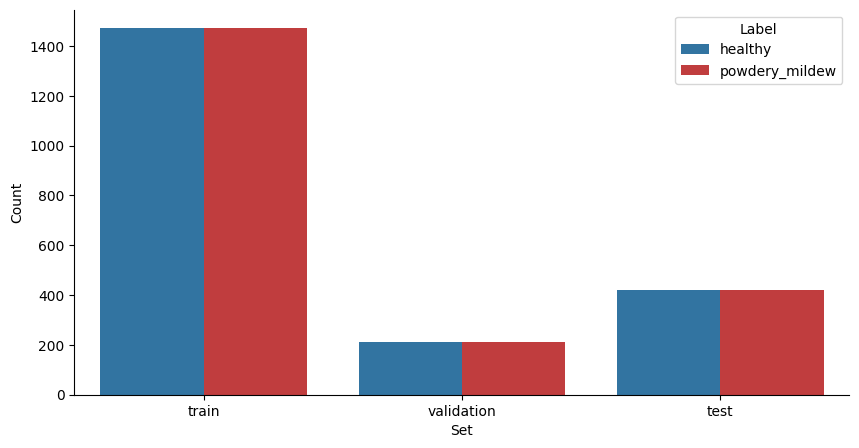

In [15]:
def get_image_count(folder, label):
    """
    Function to get image count for each label in a specific set
    and plot image data distribution.
    """
    try:
        return len(os.listdir(os.path.join(data_dir, folder, label)))
    except:
        return None

# Create a DataFrame to store the image distribution and count per set and label
sets = ['train', 'validation', 'test']
labels = ['healthy', 'powdery_mildew']
data = {
    'Set': [],
    'Label': [],
    'Count': []
}

for folder in sets:
    for label in labels:
        count = get_image_count(folder, label)
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Count'].append(count)

df_freq = pd.DataFrame(data)

# Print the image distribution and count per set and label
for folder in sets:
    print(f"\033[1m{folder.capitalize()} set:\033[0m")
    print(df_freq[df_freq['Set']==folder].to_string(index=False, header=False, justify='center'))
    print("\n")

# Plot the image distribution and count per set and label using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(data=df_freq, x='Set', y='Count', hue='Label', palette=['#1f77b4', '#d62728'])
sns.despine()
plt.savefig(f'{file_path}/img_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

**Interpretation & Insights:**

* In the bar plot representation, the 'healthy' category is indicated by the blue bars, while the 'powdery mildew' category is represented by the red bars.
* Within the train dataset, a majority of the data is contained, comprising a total of 2944 image data files. This substantial portion is further segregated into subfolders, with 'healthy' and 'powdery mildew' categories each containing 1472 image files.
* The validation set consists of 420 image data files, equally divided into subfolders containing 210 files each for 'healthy' and 'powdery mildew.'
* Likewise, the test set encompasses 844 image data files, and these, too, are evenly distributed into subfolders, with 422 files in each category.

The visualization provides a comprehensive overview of the dataset distribution across different subsets. This meticulous data distribution adheres to the prescribed 70-10-20 split ratio for training, validation, and testing.

---

# Image Data Augmentation

As observed from the metrics above, the dataset is relatively small when compared to large-scale image datasets commonly used for training CNNs. Despite its size, training a CNN with this dataset is possible, but it may be prone to overfitting. To address this issue, we will employ data augmentation techniques to artificially expand the training set.

In [16]:
# Create an ImageDataGenerator for data augmentation
augmented_image_data = ImageDataGenerator(
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.1,    # Randomly shift images horizontally by 10% of the total width
    height_shift_range=0.1,   # Randomly shift images vertically by 10% of the total height
    shear_range=0.1,          # Apply shear transformation with maximum shear of 0.1
    zoom_range=0.20,           # Randomly zoom images by up to 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    fill_mode='nearest',      # Fill points outside the input boundaries using the nearest pixel value
    rescale=1./255            # Rescale pixel values to the range [0, 1]
)

* Setting batch size, color mode, and class mode for image data generator.

In [17]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

## Augment Training Dataset Images

In [18]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode=data_color_mode,
                                               batch_size=batch_size,
                                               class_mode=data_class_mode,
                                               shuffle=True
                                               )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augment Validation Dataset Images

In [19]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode=data_color_mode,
                                                                        batch_size=batch_size,
                                                                        class_mode=data_class_mode,
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augment Test Dataset Images

In [21]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode=data_color_mode,
                                                                  batch_size=batch_size,
                                                                  class_mode=data_class_mode,
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Image

In [22]:
def plot_augmented_images(dataset_name, dataset, display_size=3):
    """
    Plot augmented images from the given dataset.
    """

    # Display the number of augmented images
    for _ in range(display_size):
        # Get the next batch of images and corresponding labels
        img, label = dataset.next()

        # Display the image
        plt.imshow(img[0])  # Selecting the first image from the batch
        plt.axis('off')     # Turn off axis ticks and labels
        plt.title(f"{dataset_name} - Augmented Image")
        plt.show()

* ## Training Image Set

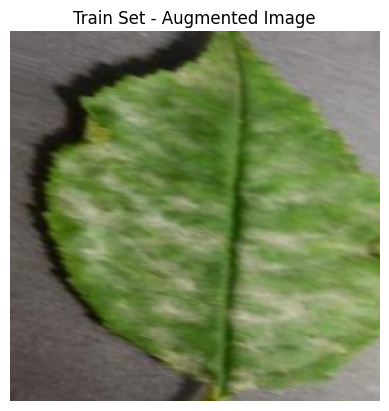

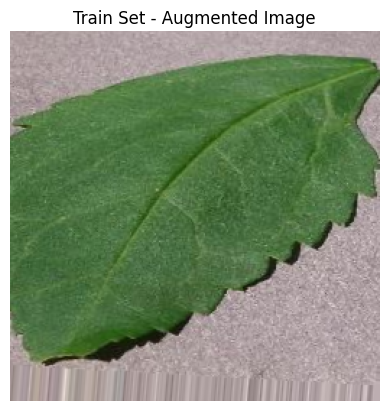

In [23]:
plot_augmented_images("Train Set", train_set, display_size=2)

* ## Validation Image Set

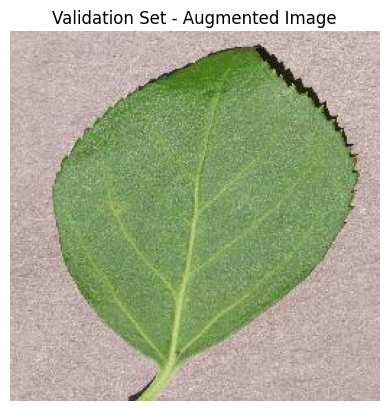

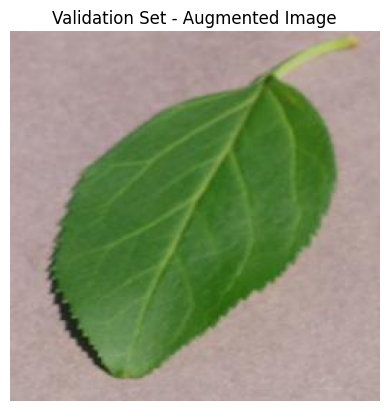

In [24]:
plot_augmented_images("Validation Set", validation_set, display_size=2)

* ## Test Image Set

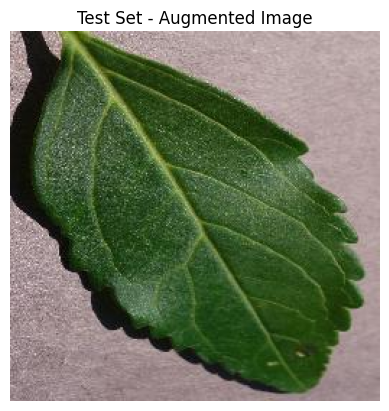

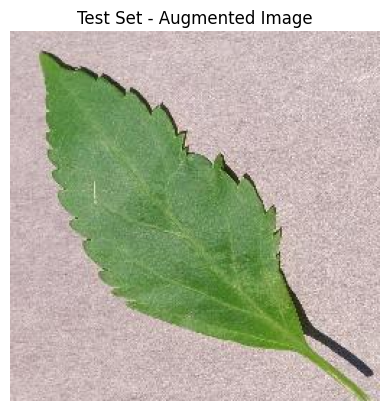

In [25]:
plot_augmented_images("Test Set", test_set, display_size=2)

Save the class indices for both the labels into a pickle file.

In [26]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")
train_set.class_indices

{'healthy': 0, 'powdery_mildew': 1}